In [162]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
from typing import Optional
import seaborn as sn

def map_range(x, from_min, from_max, to_min, to_max):
    percent = (x - from_min) / abs(from_max - from_min)
    return percent * abs(to_max - to_min) + to_min

def prepare_dataset(dataset: pd.DataFrame):
    prepared_dataset = dataset.copy(True)

    crops = prepared_dataset["Crop"].unique()
    crops.sort()

    prepared_dataset["Crop"] = prepared_dataset["Crop"].map(lambda crop: np.where(crop == crops)[0][0])
    for column_name in prepared_dataset.columns:
        if column_name == "Crop": continue
        column = prepared_dataset[column_name]
        min_value = column.min()
        max_value = column.max()
        prepared_dataset[column_name] = prepared_dataset[column_name].map(lambda x: map_range(x, min_value, max_value, -1, 1))

    return prepared_dataset, crops

def calc_distance(a: pd.Series, b: pd.Series):
    return (a.sub(b) ** 2).sum() ** 0.5

def find_farthest_neighbours(k: int, dataset: pd.DataFrame, seed=None) -> list[pd.Series]:
    rng = random.Random(seed)

    rows = list(row for _, row in dataset.iterrows())

    solutions_indexes = []
    solutions_indexes.append(rng.randint(0, len(rows)))

    def min_solution_distance(row_idx):
        return min(map(lambda solution_idx: calc_distance(rows[row_idx], rows[solution_idx]), solutions_indexes))

    for _ in range(k-1):
        distanace_iter = map(lambda row_idx: (row_idx, min_solution_distance(row_idx)), range(len(rows)))
        best_distance_idx, best_distance = next(distanace_iter)

        for i, distance in distanace_iter:
            if distance > best_distance:
                best_distance_idx = i

        solutions_indexes.append(best_distance_idx)

    return list(map(lambda idx: rows[idx], solutions_indexes))

def plot_dataset_by_label(x, y, labels, x_column, y_column):
    for label_idx, label in enumerate(labels):
        label_x = x[y == label_idx]
        plt.plot(label_x[x_column], label_x[y_column], marker='o', linewidth=0, label=label)
    plt.xlim(-1.1, 1.1)
    plt.ylim(-1.1, 1.1)
    plt.xlabel(x_column)
    plt.ylabel(y_column)

class KMeansClassifier:
    def __init__(self, k):
        self.centroids = []
        self.centroid_labels = []
        self.k = k

    def train(self,
              x: pd.DataFrame,
              y: pd.Series,
              epochs=1,
              starting_points: Optional[list[pd.Series]] = None,
              seed = None,
        ):
        if starting_points == None:
            self.centroids = find_farthest_neighbours(self.k, x, seed)
        else:
            assert len(starting_points) == self.k
            self.centroids = starting_points.copy()

        for epoch in range(epochs):
            print(f"Epoch: {epoch+1}/{epochs}")

            points_by_centroid_count = []
            points_by_centroid_sum = []
            for _ in range(self.k):
                zero_series = {}
                for column_name in x.columns:
                    zero_series[column_name] = 0
                points_by_centroid_sum.append(pd.Series(zero_series, index=x.columns, dtype=float))
                points_by_centroid_count.append(0)

            for _, row in x.iterrows():
                centroid_distances = list(map(lambda centroid: calc_distance(centroid, row), self.centroids))
                centroid_idx = centroid_distances.index(min(centroid_distances))
                points_by_centroid_sum[centroid_idx] = points_by_centroid_sum[centroid_idx].add(row)
                points_by_centroid_count[centroid_idx] += 1

            for i in range(self.k):
                self.centroids[i] = points_by_centroid_sum[i].div(points_by_centroid_count[i])

        self.centroid_labels = []
        for i, centroid in enumerate(self.centroids):
            distance_by_label = [0] * self.k

            for idx, row in x.iterrows():
                distance_by_label[y[idx]] += calc_distance(centroid, row)

            self.centroid_labels.append(distance_by_label.index(min(distance_by_label)))

    def predict(self, x: pd.Series) -> int:
        best_distance = calc_distance(x, self.centroids[0])
        best_distance_idx = 0
        for idx in range(1, len(self.centroids)):
            distance = calc_distance(x, self.centroids[idx])
            if distance < best_distance:
                best_distance_idx = idx
                best_distance = distance

        return self.centroid_labels[best_distance_idx]


# Parameters

In [69]:
dataset_filename = "dataset.csv"
test_size = 0.2
seed = 42

# Prepare dataset

In [50]:
dataset, crop_labels = prepare_dataset(pd.read_csv(dataset_filename))

train_dataset, test_dataset = train_test_split(dataset, test_size=test_size, random_state=seed)

assert type(train_dataset) == pd.DataFrame
assert type(test_dataset) == pd.DataFrame
train_x, train_y = train_dataset.drop(columns=['Crop']), train_dataset['Crop']
test_x, test_y = test_dataset.drop(columns=['Crop']), test_dataset['Crop']

dataset.head()

Nitrogen  Phosphorus  Potassium  Temperature  Humidity  pH_Value  Rainfall  \
0  0.285714   -0.471429      -0.62    -0.308228  0.580534 -0.067473  0.312916   
1  0.214286   -0.242857      -0.64    -0.257110  0.541266  0.098961  0.483349   
2 -0.142857   -0.285714      -0.61    -0.186292  0.587953  0.348438  0.751421   
3  0.057143   -0.571429      -0.65     0.013803  0.537503  0.081016  0.599811   
4  0.114286   -0.471429      -0.63    -0.351245  0.571251  0.282583  0.742461   

   Crop  
0    20  
1    20  
2    20  
3    20  
4    20

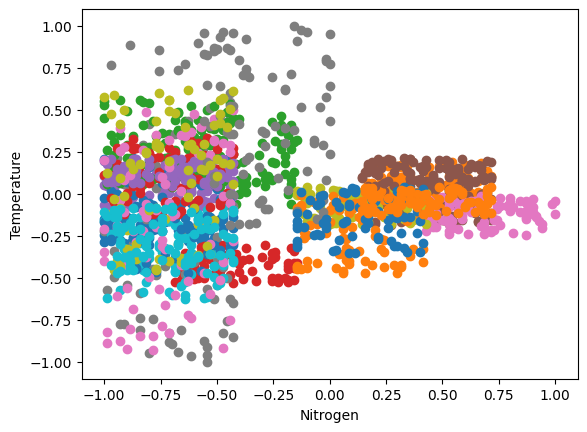

In [65]:
plot_dataset_by_label(train_x, train_y, crop_labels, 'Nitrogen', 'Temperature')
plt.show()

# Starting points

In [11]:
starting_points = find_farthest_neighbours(len(crop_labels), train_x, seed=seed)
print(starting_points)

[Nitrogen       0.514286
Phosphorus    -0.771429
Potassium     -0.530000
Temperature    0.151806
Humidity       0.878868
pH_Value      -0.134800
Rainfall      -0.979702
Name: 1497, dtype: float64, Nitrogen      -0.842857
Phosphorus     0.700000
Potassium      0.990000
Temperature   -0.735768
Humidity       0.535356
pH_Value      -0.111590
Rainfall      -0.632194
Name: 1294, dtype: float64, Nitrogen      -0.842857
Phosphorus    -0.557143
Potassium     -0.740000
Temperature    0.095843
Humidity      -0.124593
pH_Value      -0.076037
Rainfall      -0.424842
Name: 1130, dtype: float64, Nitrogen      -0.857143
Phosphorus    -1.000000
Potassium     -1.000000
Temperature   -0.289098
Humidity       0.798693
pH_Value       0.341483
Rainfall      -0.333411
Name: 1638, dtype: float64, Nitrogen      -0.542857
Phosphorus     0.042857
Potassium     -0.830000
Temperature   -0.130834
Humidity       0.122151
pH_Value       0.089300
Rainfall      -0.761466
Name: 860, dtype: float64, Nitrogen       0.542

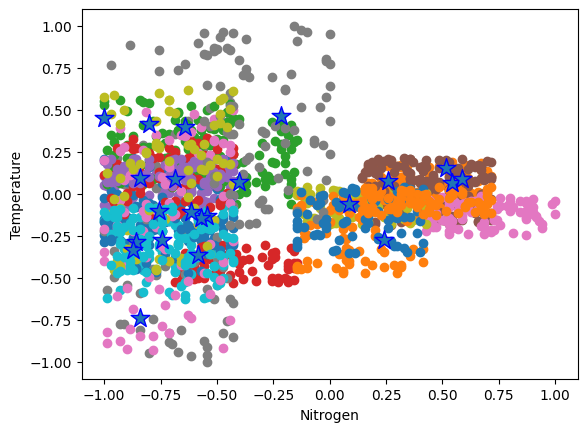

In [68]:
plot_dataset_by_label(train_x, train_y, crop_labels, 'Nitrogen', 'Temperature')
plt.scatter(list(p['Nitrogen'] for p in starting_points), list(p['Temperature'] for p in starting_points), marker='*', s=200, edgecolors='b', zorder=10)
plt.show()

# Train model & visualize

In [168]:
model = KMeansClassifier(len(crop_labels))

model.train(train_x, train_y, starting_points=starting_points, seed=seed, epochs=10)

# print(model.centroids)
# print(model.centroid_labels)

Epoch: 1/10
Epoch: 2/10
Epoch: 3/10
Epoch: 4/10
Epoch: 5/10
Epoch: 6/10
Epoch: 7/10
Epoch: 8/10
Epoch: 9/10
Epoch: 10/10


Accuracy: 70.45%


Text(50.72222222222221, 0.5, 'Predicted')

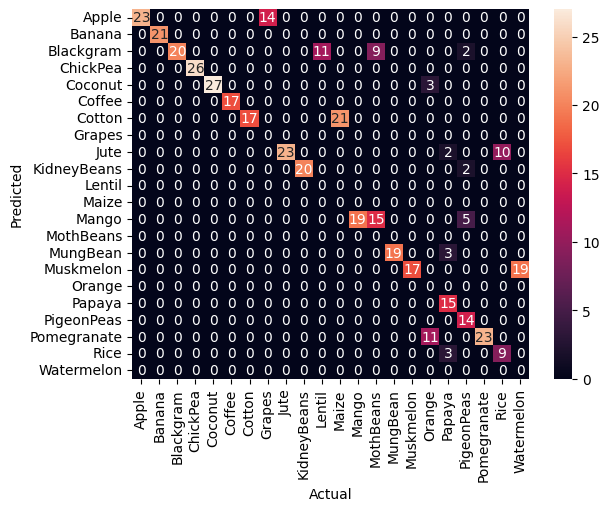

In [169]:
confusion_matrix = []
for _ in range(len(crop_labels)):
    confusion_matrix.append([0] * len(crop_labels))

total_correct = 0

for idx, row in test_x.iterrows():
    predicted = model.predict(row)
    actual = test_y.get(idx)
    confusion_matrix[predicted][actual] += 1

    if predicted == actual:
        total_correct += 1

print(f"Accuracy: {total_correct / len(test_x) * 100:.2f}%")

sn.heatmap(confusion_matrix, annot=True, xticklabels=crop_labels, yticklabels=crop_labels)
plt.xlabel("Actual")
plt.ylabel("Predicted")